In [40]:
# PACKAGE INSTALLATION (Run once)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import re
import nltk
from nltk.tokenize import word_tokenize
import time
import warnings
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except Exception as e:
    print("TensorFlow/Keras could not be loaded:", e)
    KERAS_AVAILABLE = False

warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("All packages imported successfully!")
print(f"tensorflow: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")


All packages imported successfully!
tensorflow: 2.20.0
Pandas version: 2.2.3
NumPy version: 2.1.3
Scikit-learn version: 1.6.1


In [41]:
# CONFIGURATION
DATA_PATH = r'D:\downloads\spam.csv'  # Update with your path

# Model parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_FEATURES = 5000  # TF-IDF features
LSTM_MAX_WORDS = 5000
LSTM_MAX_LEN = 100
LSTM_EPOCHS = 10

# Results storage
results_list = []
models_dict = {}

print(" Configuration loaded successfully!")

 Configuration loaded successfully!


In [42]:
# DATA LOADING
def load_spam_data(filepath=DATA_PATH):
    """
    Load SMS Spam Collection dataset from CSV
    """
    print("="*70)
    print(" DATA LOADING ".center(70))
    print("="*70)
    
    try:
        # Try different encodings
        encodings = ['latin-1', 'utf-8', 'iso-8859-1']
        
        for encoding in encodings:
            try:
                df = pd.read_csv(filepath, encoding=encoding)
                print(f" Successfully loaded with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
        
        # Handle different column formats
        if 'v1' in df.columns and 'v2' in df.columns:
            df = df[['v1', 'v2']]
            df.columns = ['label', 'message']
        elif 'label' in df.columns and 'message' in df.columns:
            df = df[['label', 'message']]
        else:
            df = df.iloc[:, :2]
            df.columns = ['label', 'message']
        
        # Clean data
        df = df.dropna()
        df['label'] = df['label'].str.lower().map({'ham': 0, 'spam': 1})
        df = df[df['label'].isin([0, 1])]
        
        # Display statistics
        print(f"\n📊 Dataset Statistics:")
        print(f"  • Total messages: {len(df):,}")
        print(f"  • Spam messages: {df['label'].sum():,} ({df['label'].sum()/len(df)*100:.2f}%)")
        print(f"  • Ham messages: {(df['label']==0).sum():,} ({(df['label']==0).sum()/len(df)*100:.2f}%)")
        print(f"  • Average message length: {df['message'].str.len().mean():.0f} characters")
        
        return df
    
    except FileNotFoundError:
        print(f" Error: File '{filepath}' not found!")
        print("\n Please ensure spam.csv is in the same directory as this notebook")
        print("   Download from: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
        return None
    except Exception as e:
        print(f" Error loading data: {str(e)}")
        return None

# Load the dataset
df = load_spam_data()

# Display first few rows
if df is not None:
    print("\n Sample Data:")
    display(df.head(10))

                             DATA LOADING                             
 Successfully loaded with latin-1 encoding

📊 Dataset Statistics:
  • Total messages: 5,572
  • Spam messages: 747 (13.41%)
  • Ham messages: 4,825 (86.59%)
  • Average message length: 80 characters

 Sample Data:


,label,message
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"
5,1,FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for ...
6,0,Even my brother is not like to speak with me. They treat me like aids patent.
7,0,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...
8,1,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To ...
9,1,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with came...


                      EXPLORATORY DATA ANALYSIS                       

 Message Length Statistics by Class:
      message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
0             4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0   
1              747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
0         4825.0  14.200622  11.424511  1.0   7.0  11.0  19.0  171.0  
1          747.0  23.851406   5.811898  2.0  22.0  25.0  28.0   35.0  


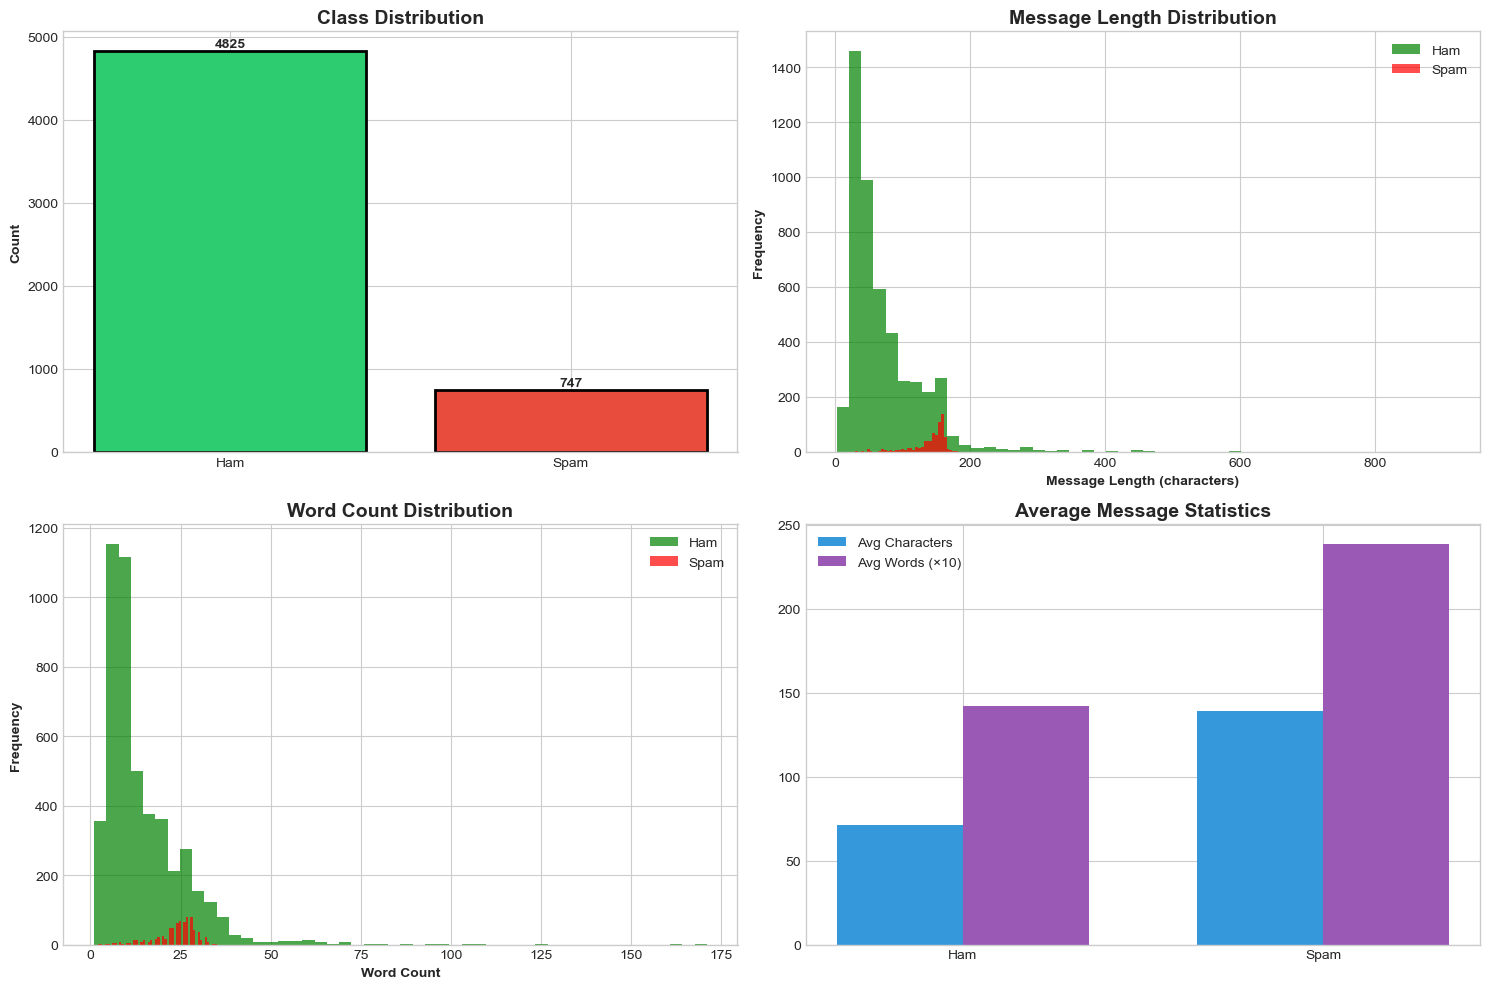


 Sample SPAM Messages:
1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it s...
3. WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To clai...
4. Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera f...
5. SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6day...

 Sample HAM Messages:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...
2. Ok lar... Joking wif u oni......
3. U dun say so early hor... U c already then say......
4. Nah I don't think he goes to usf, he lives around here though...
5. Even my brother is not like to speak with me. They treat me like aids patent....


In [43]:
# EXPLORATORY DATA ANALYSIS
print("="*70)
print(" EXPLORATORY DATA ANALYSIS ".center(70))
print("="*70)

# Add message length
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()

# Statistics by class
print("\n Message Length Statistics by Class:")
print(df.groupby('label')[['message_length', 'word_count']].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution
ax1 = axes[0, 0]
class_counts = df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.bar(['Ham', 'Spam'], class_counts.values, color=colors, edgecolor='black', linewidth=2)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

# 2. Message length distribution
ax2 = axes[0, 1]
df[df['label']==0]['message_length'].hist(bins=50, alpha=0.7, label='Ham', color='green', ax=ax2)
df[df['label']==1]['message_length'].hist(bins=50, alpha=0.7, label='Spam', color='red', ax=ax2)
ax2.set_title('Message Length Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Message Length (characters)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.legend()

# 3. Word count distribution
ax3 = axes[1, 0]
df[df['label']==0]['word_count'].hist(bins=50, alpha=0.7, label='Ham', color='green', ax=ax3)
df[df['label']==1]['word_count'].hist(bins=50, alpha=0.7, label='Spam', color='red', ax=ax3)
ax3.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Word Count', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.legend()

# 4. Average lengths comparison
ax4 = axes[1, 1]
avg_lengths = df.groupby('label')['message_length'].mean()
avg_words = df.groupby('label')['word_count'].mean()
x = np.arange(2)
width = 0.35
ax4.bar(x - width/2, avg_lengths.values, width, label='Avg Characters', color='#3498db')
ax4.bar(x + width/2, avg_words.values*10, width, label='Avg Words (×10)', color='#9b59b6')
ax4.set_title('Average Message Statistics', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['Ham', 'Spam'])
ax4.legend()

plt.tight_layout()
plt.show()

# Sample messages
print("\n Sample SPAM Messages:")
for i, msg in enumerate(df[df['label']==1]['message'].head(5), 1):
    print(f"{i}. {msg[:100]}...")

print("\n Sample HAM Messages:")
for i, msg in enumerate(df[df['label']==0]['message'].head(5), 1):
    print(f"{i}. {msg[:100]}...")
    

In [44]:
# TEXT PREPROCESSING
def preprocess_text(text):
    """
    Clean and preprocess text message
    """
    # Lowercase
    text = text.lower()
    
    # Replace URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'urlplaceholder', text)
    
    # Replace phone numbers
    text = re.sub(r'\b\d{10,}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', 'phoneplaceholder', text)
    
    # Replace emails
    text = re.sub(r'\S+@\S+', 'emailplaceholder', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove short tokens
    tokens = [t for t in tokens if len(t) > 2]
    
    return ' '.join(tokens)

def extract_features(df):
    """
    Extract statistical features
    """
    features = pd.DataFrame()
    features['char_count'] = df['message'].str.len()
    features['word_count'] = df['message'].str.split().str.len()
    features['caps_ratio'] = df['message'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
    )
    features['digit_ratio'] = df['message'].apply(
        lambda x: sum(1 for c in x if c.isdigit()) / max(len(x), 1)
    )
    features['has_url'] = df['message'].str.contains('http|www', case=False).astype(int)
    features['has_phone'] = df['message'].str.contains(r'\d{10}', regex=True).astype(int)
    features['exclamation_count'] = df['message'].str.count('!')
    features['question_count'] = df['message'].str.count('\?')
    
    return features

print("="*70)
print(" DATA PREPROCESSING ".center(70))
print("="*70)

# Apply preprocessing
print("\n Cleaning text messages...")
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Extract features
print(" Extracting statistical features...")
stat_features = extract_features(df)

# Train-test split
print("⚙️ Splitting data (80% train, 20% test)...")
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['cleaned_message'], 
    df['label'], 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=df['label']
)

stat_train, stat_test = train_test_split(
    stat_features,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['label']
)

print(f"\n Preprocessing complete!")
print(f"   • Training set: {len(X_train_text):,} messages")
print(f"   • Test set: {len(X_test_text):,} messages")

# Show examples
print("\n Preprocessing Examples:")
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_message'].iloc[i][:80]}...")

                          DATA PREPROCESSING                          

 Cleaning text messages...
 Extracting statistical features...
⚙️ Splitting data (80% train, 20% test)...

 Preprocessing complete!
   • Training set: 4,457 messages
   • Test set: 1,115 messages

 Preprocessing Examples:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
Cleaned:  until jurong point crazy available only bugis great world buffet cine there got ...

Original: Ok lar... Joking wif u oni......
Cleaned:  lar joking wif oni...

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
Cleaned:  free entry wkly comp win cup final tkts may text receive entry question std txt ...


In [45]:

# TF-IDF VECTORIZATION
print("="*70)
print(" TF-IDF FEATURE EXTRACTION ".center(70))
print("="*70)

# Create vectorizer
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

# Transform text to TF-IDF features
print(f"\n Creating TF-IDF features (max {MAX_FEATURES} features)...")
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"\n TF-IDF vectorization complete!")
print(f"   • Training matrix shape: {X_train_tfidf.shape}")
print(f"   • Test matrix shape: {X_test_tfidf.shape}")
print(f"   • Vocabulary size: {len(vectorizer.get_feature_names_out()):,}")

# Show top features
feature_names = vectorizer.get_feature_names_out()
print(f"\n Sample features: {', '.join(feature_names[:20])}")

                      TF-IDF FEATURE EXTRACTION                       

 Creating TF-IDF features (max 5000 features)...

 TF-IDF vectorization complete!
   • Training matrix shape: (4457, 5000)
   • Test matrix shape: (1115, 5000)
   • Vocabulary size: 5,000

 Sample features: aathi, aathi love, abi, abiola, able, able deliver, able get, able pay, about, about how, about mins, about over, about smiling, about something, about stuff, about that, about the, about this, about wan, about what


                        NAIVE BAYES CLASSIFIER                        

 Training Naive Bayes...

 Naive Bayes Results:
   • Accuracy:  97.22%
   • Precision: 99.17%
   • Recall:    79.87%
   • F1-Score:  88.48%
   • Training Time: 0.004s

 Confusion Matrix:
[[965   1]
 [ 30 119]]

 Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.80      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



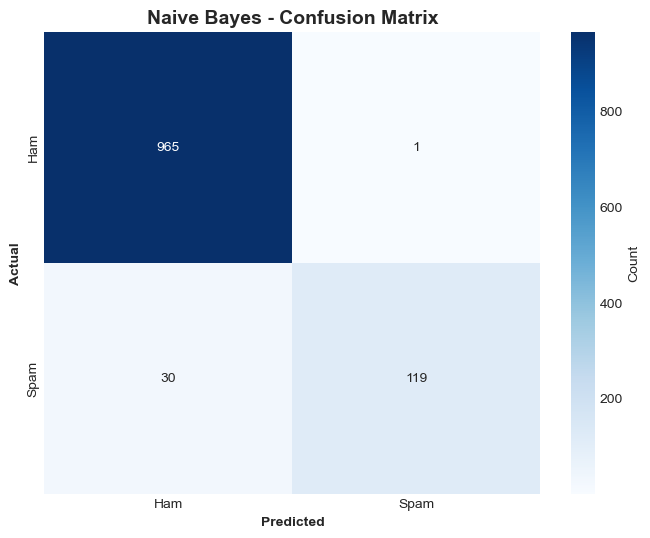

In [46]:
# MODEL 1: NAIVE BAYES
print("="*70)
print(" NAIVE BAYES CLASSIFIER ".center(70))
print("="*70)

# Train model
print("\n Training Naive Bayes...")
start_time = time.time()

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

train_time = time.time() - start_time

# Predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Metrics
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_cm = confusion_matrix(y_test, y_pred_nb)

# Store results
nb_results = {
    'name': 'Naive Bayes',
    'model': nb_model,
    'accuracy': nb_accuracy,
    'precision': nb_precision,
    'recall': nb_recall,
    'f1_score': nb_f1,
    'train_time': train_time,
    'confusion_matrix': nb_cm,
    'predictions': y_pred_nb
}
results_list.append(nb_results)
models_dict['Naive Bayes'] = nb_model

# Display results
print(f"\n Naive Bayes Results:")
print(f"   • Accuracy:  {nb_accuracy*100:.2f}%")
print(f"   • Precision: {nb_precision*100:.2f}%")
print(f"   • Recall:    {nb_recall*100:.2f}%")
print(f"   • F1-Score:  {nb_f1*100:.2f}%")
print(f"   • Training Time: {train_time:.3f}s")

print(f"\n Confusion Matrix:")
print(nb_cm)

# Classification report
print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Ham', 'Spam']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
            cbar_kws={'label': 'Count'})
plt.title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.show()

                         LOGISTIC REGRESSION                          

 Training Logistic Regression...

 Logistic Regression Results:
   • Accuracy:  97.67%
   • Precision: 97.67%
   • Recall:    84.56%
   • F1-Score:  90.65%
   • Training Time: 0.024s

 Confusion Matrix:
[[963   3]
 [ 23 126]]


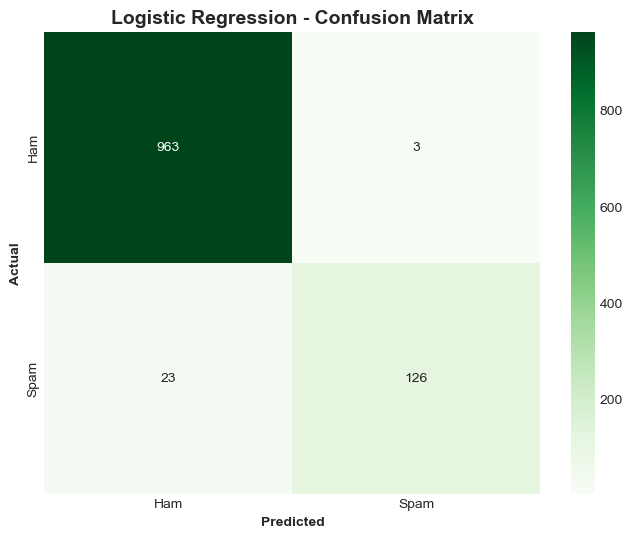

In [47]:
# MODEL 2: LOGISTIC REGRESSION
print("="*70)
print(" LOGISTIC REGRESSION ".center(70))
print("="*70)

# Train model
print("\n Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, C=1.0)
lr_model.fit(X_train_tfidf, y_train)

train_time = time.time() - start_time

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_cm = confusion_matrix(y_test, y_pred_lr)

# Store results
lr_results = {
    'name': 'Logistic Regression',
    'model': lr_model,
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'train_time': train_time,
    'confusion_matrix': lr_cm,
    'predictions': y_pred_lr
}
results_list.append(lr_results)
models_dict['Logistic Regression'] = lr_model

# Display results
print(f"\n Logistic Regression Results:")
print(f"   • Accuracy:  {lr_accuracy*100:.2f}%")
print(f"   • Precision: {lr_precision*100:.2f}%")
print(f"   • Recall:    {lr_recall*100:.2f}%")
print(f"   • F1-Score:  {lr_f1*100:.2f}%")
print(f"   • Training Time: {train_time:.3f}s")

print(f"\n Confusion Matrix:")
print(lr_cm)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.show()

                       RANDOM FOREST CLASSIFIER                       

 Training Random Forest...

 Random Forest Results:
   • Accuracy:  97.85%
   • Precision: 98.45%
   • Recall:    85.23%
   • F1-Score:  91.37%
   • Training Time: 0.550s

 Confusion Matrix:
[[964   2]
 [ 22 127]]

 Top 10 Important Features:
                    feature  importance
3033       phoneplaceholder    0.081357
4245                    txt    0.043652
549   call phoneplaceholder    0.034188
530                    call    0.026286
4310         urlplaceholder    0.023762
1311                   free    0.022845
3313                  reply    0.017889
711                   claim    0.017577
3869                   text    0.011761
2418                 mobile    0.010514


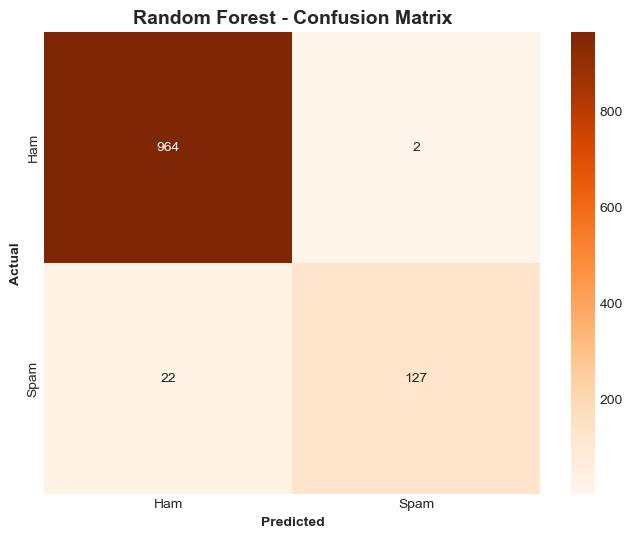

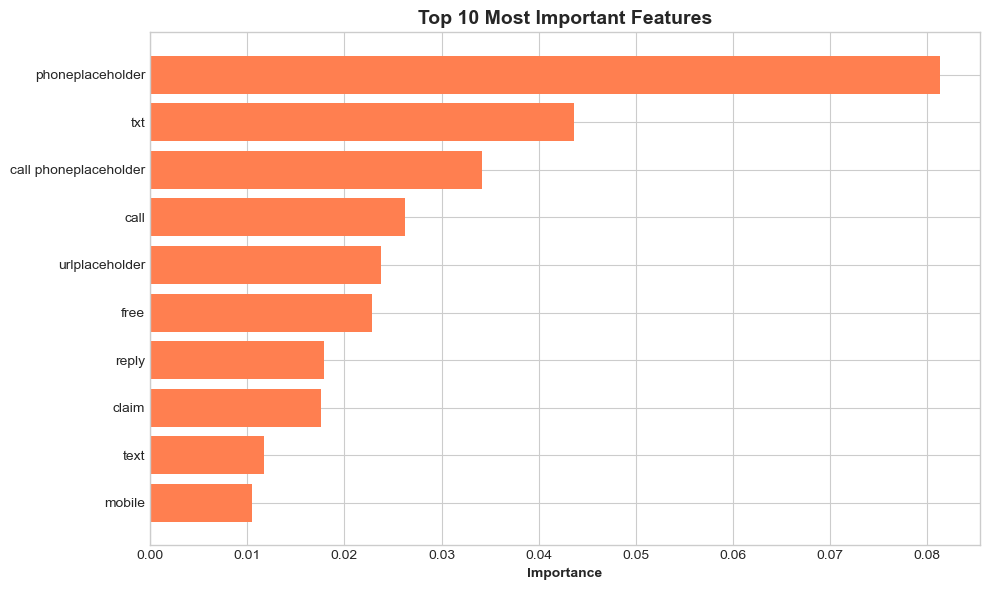

In [48]:
# MODEL 3: RANDOM FOREST
print("="*70)
print(" RANDOM FOREST CLASSIFIER ".center(70))
print("="*70)

# Train model
print("\n Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

train_time = time.time() - start_time

# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Store results
rf_results = {
    'name': 'Random Forest',
    'model': rf_model,
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'train_time': train_time,
    'confusion_matrix': rf_cm,
    'predictions': y_pred_rf
}
results_list.append(rf_results)
models_dict['Random Forest'] = rf_model

# Display results
print(f"\n Random Forest Results:")
print(f"   • Accuracy:  {rf_accuracy*100:.2f}%")
print(f"   • Precision: {rf_precision*100:.2f}%")
print(f"   • Recall:    {rf_recall*100:.2f}%")
print(f"   • F1-Score:  {rf_f1*100:.2f}%")
print(f"   • Training Time: {train_time:.3f}s")

print(f"\n Confusion Matrix:")
print(rf_cm)

# Feature importance
print(f"\n Top 10 Important Features:")
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print(feature_importance)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.xlabel('Importance', fontweight='bold')
plt.title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

                         LSTM NEURAL NETWORK                          

 Tokenizing text for LSTM...
 Sequences created!
   • Training sequences: (4457, 100)
   • Test sequences: (1115, 100)

 Building LSTM architecture...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

 Training LSTM (this may take a few minutes)...
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8965 - loss: 0.2885 - val_accuracy: 0.9585 - val_loss: 0.1243
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9846 - loss: 0.0593 - val_accuracy: 0.9776 - val_loss: 0.0828
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9933 - loss: 0.0283 - val_accuracy: 0.9787 - val_loss: 0.0733
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9955 - loss: 0.0168 - val_accuracy: 0.9809 - val_loss: 0.0877
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9986 - loss: 0.0072 - val_accuracy: 0.9821 - val_loss: 0.0951
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9809 - val_loss: 0.1152
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step  

 LSTM Results:
   • Accuracy:  98.65%
   • Precision: 98.55%
   • Recall:    91.28%
   • F1-Score:  94.77%
   • Training Time: 34.39s


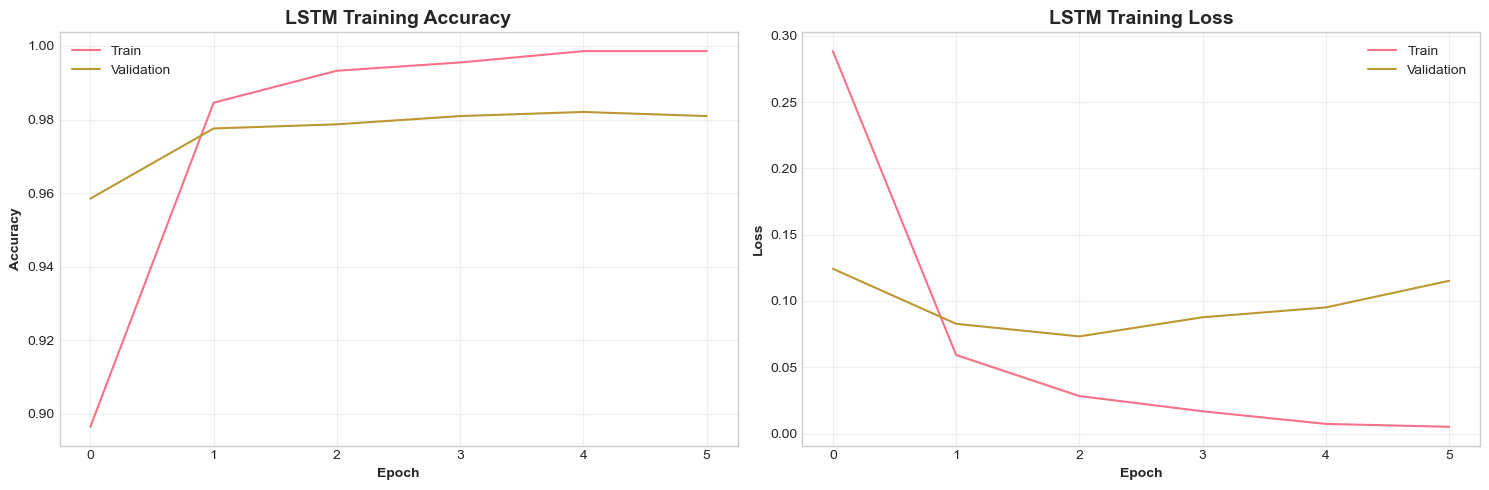

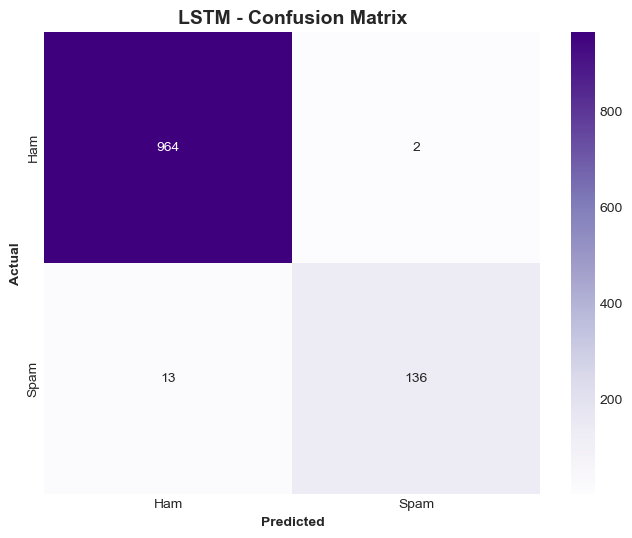

In [49]:
# MODEL 4: LSTM (DEEP LEARNING)
if KERAS_AVAILABLE:
    print("="*70)
    print(" LSTM NEURAL NETWORK ".center(70))
    print("="*70)
    
    # Tokenization
    print("\n Tokenizing text for LSTM...")
    tokenizer = Tokenizer(num_words=LSTM_MAX_WORDS)
    tokenizer.fit_on_texts(X_train_text)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=LSTM_MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=LSTM_MAX_LEN)
    
    print(f" Sequences created!")
    print(f"   • Training sequences: {X_train_pad.shape}")
    print(f"   • Test sequences: {X_test_pad.shape}")
    
    # Build LSTM model
    print("\n Building LSTM architecture...")
    lstm_model = Sequential([
        Embedding(LSTM_MAX_WORDS, 128, input_length=LSTM_MAX_LEN),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    lstm_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(lstm_model.summary())
    
    # Train model
    print("\n Training LSTM (this may take a few minutes)...")
    start_time = time.time()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = lstm_model.fit(
        X_train_pad, y_train,
        epochs=LSTM_EPOCHS,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict on test set
    y_pred_lstm_prob = lstm_model.predict(X_test_pad)
    y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()
    
    # Compute metrics
    lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
    lstm_precision = precision_score(y_test, y_pred_lstm)
    lstm_recall = recall_score(y_test, y_pred_lstm)
    lstm_f1 = f1_score(y_test, y_pred_lstm)
    lstm_cm = confusion_matrix(y_test, y_pred_lstm)
    
    # Store results
    lstm_results = {
        'name': 'LSTM',
        'model': lstm_model,
        'accuracy': lstm_accuracy,
        'precision': lstm_precision,
        'recall': lstm_recall,
        'f1_score': lstm_f1,
        'train_time': train_time,
        'confusion_matrix': lstm_cm,
        'predictions': y_pred_lstm,
        'history': history
    }
    results_list.append(lstm_results)
    
    # Add LSTM to models_dict for interactive use
    models_dict["LSTM"] = lstm_model
    
    # Save tokenizer and max length for interactive predictions
    lstm_artifacts = {
        "tokenizer": tokenizer,
        "max_len": LSTM_MAX_LEN
    }
    
    # Display results
    print(f"\n LSTM Results:")
    print(f"   • Accuracy:  {lstm_accuracy*100:.2f}%")
    print(f"   • Precision: {lstm_precision*100:.2f}%")
    print(f"   • Recall:    {lstm_recall*100:.2f}%")
    print(f"   • F1-Score:  {lstm_f1*100:.2f}%")
    print(f"   • Training Time: {train_time:.2f}s")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('LSTM Training Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('LSTM Training Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Loss', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Purples', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title('LSTM - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.show()
    
else:
    print("Skipping LSTM - TensorFlow not available")
    print("Install with: pip install tensorflow")


In [50]:

# RESULTS COMPARISON
print("="*70)
print(" COMPREHENSIVE RESULTS COMPARISON ".center(70))
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [r['name'] for r in results_list],
    'Accuracy (%)': [r['accuracy']*100 for r in results_list],
    'Precision (%)': [r['precision']*100 for r in results_list],
    'Recall (%)': [r['recall']*100 for r in results_list],
    'F1-Score (%)': [r['f1_score']*100 for r in results_list],
    'Training Time (s)': [r['train_time'] for r in results_list]
})

# Display table
print("\n Performance Metrics Summary:\n")
display(comparison_df.style.background_gradient(cmap='YlGn', subset=['Accuracy (%)', 'F1-Score (%)'])
                          .format(precision=2))

# Find best model
best_model_idx = comparison_df['F1-Score (%)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score (%)']

print(f"\n BEST MODEL: {best_model_name} with F1-Score of {best_f1:.2f}%")

# Error analysis
print("\n Confusion Matrix Analysis:\n")
for result in results_list:
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    total_errors = fp + fn
    error_rate = (total_errors / (tn + fp + fn + tp)) * 100
    fpr = (fp / (fp + tn)) * 100  # False Positive Rate
    fnr = (fn / (fn + tp)) * 100  # False Negative Rate
    
    print(f"{result['name']}:")
    print(f"  • True Negatives (TN): {tn} | True Positives (TP): {tp}")
    print(f"  • False Positives (FP): {fp} | False Negatives (FN): {fn}")
    print(f"  • Error Rate: {error_rate:.2f}%")
    print(f"  • False Positive Rate: {fpr:.2f}%")
    print(f"  • False Negative Rate: {fnr:.2f}%")
    print()
    

                   COMPREHENSIVE RESULTS COMPARISON                   

 Performance Metrics Summary:



,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%),Training Time (s)
0,Naive Bayes,97.22,99.17,79.87,88.48,0.00
1,Logistic Regression,97.67,97.67,84.56,90.65,0.02
2,Random Forest,97.85,98.45,85.23,91.37,0.55
3,LSTM,98.65,98.55,91.28,94.77,34.39



 BEST MODEL: LSTM with F1-Score of 94.77%

 Confusion Matrix Analysis:

Naive Bayes:
  • True Negatives (TN): 965 | True Positives (TP): 119
  • False Positives (FP): 1 | False Negatives (FN): 30
  • Error Rate: 2.78%
  • False Positive Rate: 0.10%
  • False Negative Rate: 20.13%

Logistic Regression:
  • True Negatives (TN): 963 | True Positives (TP): 126
  • False Positives (FP): 3 | False Negatives (FN): 23
  • Error Rate: 2.33%
  • False Positive Rate: 0.31%
  • False Negative Rate: 15.44%

Random Forest:
  • True Negatives (TN): 964 | True Positives (TP): 127
  • False Positives (FP): 2 | False Negatives (FN): 22
  • Error Rate: 2.15%
  • False Positive Rate: 0.21%
  • False Negative Rate: 14.77%

LSTM:
  • True Negatives (TN): 964 | True Positives (TP): 136
  • False Positives (FP): 2 | False Negatives (FN): 13
  • Error Rate: 1.35%
  • False Positive Rate: 0.21%
  • False Negative Rate: 8.72%



                      GENERATING VISUALIZATIONS                       
 Saved: spam_detection_results.png


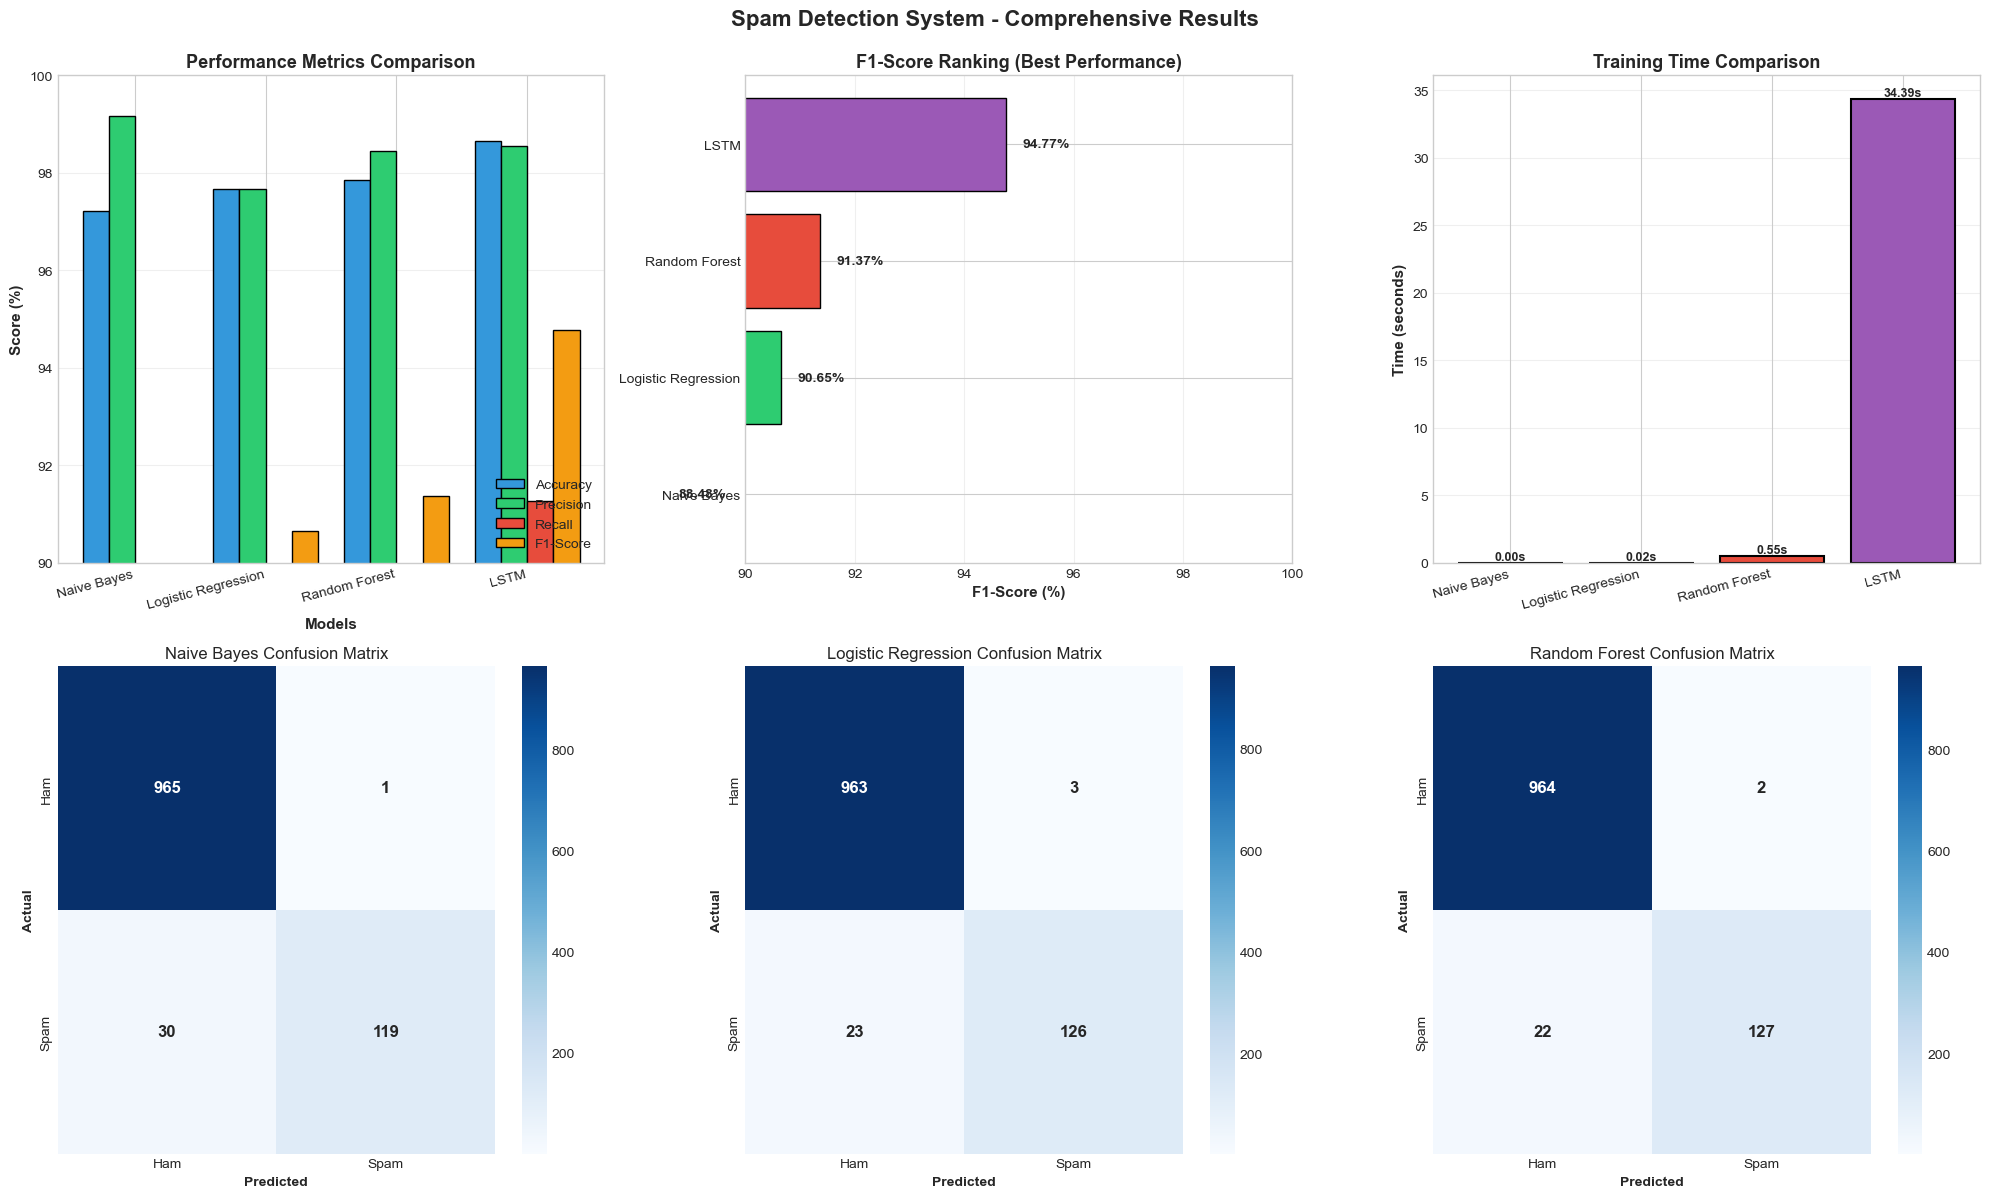

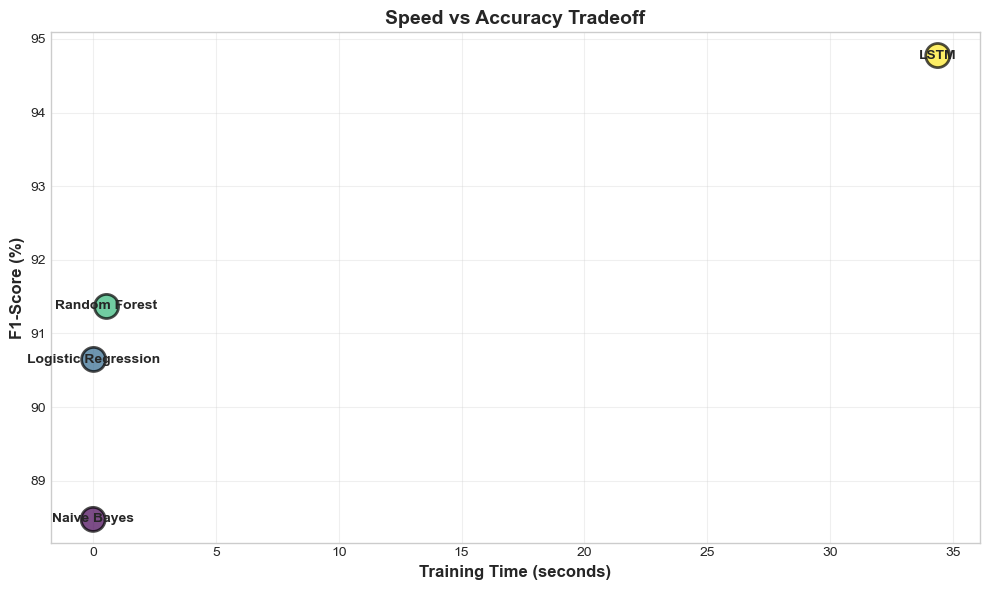

In [51]:
# COMPREHENSIVE VISUALIZATIONS
print("="*70)
print(" GENERATING VISUALIZATIONS ".center(70))
print("="*70)

# Prepare data
models = [r['name'] for r in results_list]
accuracies = [r['accuracy']*100 for r in results_list]
precisions = [r['precision']*100 for r in results_list]
recalls = [r['recall']*100 for r in results_list]
f1_scores = [r['f1_score']*100 for r in results_list]
times = [r['train_time'] for r in results_list]

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Performance Metrics Comparison (Bar Chart)
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(models))
width = 0.2
ax1.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='#3498db', edgecolor='black')
ax1.bar(x - 0.5*width, precisions, width, label='Precision', color='#2ecc71', edgecolor='black')
ax1.bar(x + 0.5*width, recalls, width, label='Recall', color='#e74c3c', edgecolor='black')
ax1.bar(x + 1.5*width, f1_scores, width, label='F1-Score', color='#f39c12', edgecolor='black')
ax1.set_xlabel('Models', fontweight='bold', fontsize=11)
ax1.set_ylabel('Score (%)', fontweight='bold', fontsize=11)
ax1.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim([90, 100])
ax1.grid(axis='y', alpha=0.3)

# 2. F1-Score Ranking (Horizontal Bar)
ax2 = plt.subplot(2, 3, 2)
colors_map = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
sorted_indices = np.argsort(f1_scores)
sorted_models = [models[i] for i in sorted_indices]
sorted_f1 = [f1_scores[i] for i in sorted_indices]
sorted_colors = [colors_map[i % len(colors_map)] for i in sorted_indices]
bars = ax2.barh(sorted_models, sorted_f1, color=sorted_colors, edgecolor='black')
ax2.set_xlabel('F1-Score (%)', fontweight='bold', fontsize=11)
ax2.set_title('F1-Score Ranking (Best Performance)', fontweight='bold', fontsize=13)
ax2.set_xlim([90, 100])
for i, (bar, score) in enumerate(zip(bars, sorted_f1)):
    ax2.text(score + 0.3, i, f'{score:.2f}%', va='center', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Training Time Comparison
ax3 = plt.subplot(2, 3, 3)
bars = ax3.bar(models, times, color=colors_map[:len(models)], edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Time (seconds)', fontweight='bold', fontsize=11)
ax3.set_title('Training Time Comparison', fontweight='bold', fontsize=13)
ax3.set_xticklabels(models, rotation=15, ha='right')
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4-7. Confusion Matrices
for idx, result in enumerate(results_list[:3]):  # display only up to 3 confusion matrices
    ax = plt.subplot(2, 3, idx + 4)  # starts at 4 → positions 4, 5, 6
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax,
                annot_kws={'size': 12, 'weight': 'bold'})
    ax.set_title(f"{result['name']} Confusion Matrix")
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')

plt.suptitle('Spam Detection System - Comprehensive Results', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('spam_detection_results.png', dpi=300, bbox_inches='tight')
print(" Saved: spam_detection_results.png")
plt.show()

# Additional: Speed vs Accuracy Tradeoff
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(times, f1_scores, s=300, c=range(len(models)), 
                     cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)
for i, model in enumerate(models):
    ax.annotate(model, (times[i], f1_scores[i]), 
                fontweight='bold', ha='center', va='center')
ax.set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=12)
ax.set_ylabel('F1-Score (%)', fontweight='bold', fontsize=12)
ax.set_title('Speed vs Accuracy Tradeoff', fontweight='bold', fontsize=14)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# INTERACTIVE MESSAGE CLASSIFICATION
print("="*70)
print(" INTERACTIVE SPAM DETECTION ".center(70))
print("="*70)

def classify_new_message(message, model_name='Random Forest'):
    cleaned = preprocess_text(message)

    if model_name not in models_dict:
        return None

    model = models_dict[model_name]

    # --- LSTM special case ---
    if model_name == "LSTM":
        seq = lstm_artifacts["tokenizer"].texts_to_sequences([cleaned])
        pad = pad_sequences(seq, maxlen=lstm_artifacts["max_len"])
        proba = model.predict(pad)[0][0]
        prediction = int(proba > 0.5)
        confidence = proba*100 if prediction==1 else (1-proba)*100
    else:
        # TF-IDF models
        features = vectorizer.transform([cleaned])
        prediction = model.predict(features)[0]

        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(features)[0]
            confidence = proba[prediction] * 100
        else:
            confidence = None

    return {
        "original": message,
        "cleaned": cleaned,
        "prediction": "SPAM" if prediction == 1 else "HAM",
        "confidence": confidence,
        "model_used": model_name
    }

#  Ask the user directly for input
print("\nType 'quit' to exit.")
print("Available models:", ", ".join(models_dict.keys()))
print("="*70)

while True:
    user_message = input("\n  Enter a message to test: ").strip()
    
    if user_message.lower() in ['quit', 'exit', 'q']:
        print("\n Exiting interactive spam detector...")
        break
    
    if not user_message:
        print("  Please enter a valid message.")
        continue
    
    # Let user choose model (optional)
    model_choice = input(" Choose model (press Enter for Random Forest): ").strip()
    if not model_choice:
        model_choice = 'Random Forest'
    
    if model_choice not in models_dict:
        print(f" Model '{model_choice}' not found. Using Random Forest instead.")
        model_choice = 'Random Forest'
    
    # Classify message
    result = classify_new_message(user_message, model_choice)
    
    # Display formatted results
    print("\n" + "="*70)
    print(" CLASSIFICATION RESULT ".center(70))
    print("="*70)
    print(f" Original Message:\n   {result['original']}")
    print(f"\n Cleaned Message:\n   {result['cleaned']}")
    print(f"\n Prediction: {'🚨 SPAM' if result['prediction']=='SPAM' else '✅ HAM'}")
    if result['confidence']:
        print(f" Confidence: {result['confidence']:.2f}%")
    print(f" Model Used: {result['model_used']}")
    print("="*70)


                      INTERACTIVE SPAM DETECTION                      

Type 'quit' to exit.
Available models: Naive Bayes, Logistic Regression, Random Forest, LSTM



  Enter a message to test:  Congratulations! You’ve won a free iPhone. Click this link to claim your prize now
 Choose model (press Enter for Random Forest):  



                        CLASSIFICATION RESULT                         
 Original Message:
   Congratulations! You’ve won a free iPhone. Click this link to claim your prize now

 Cleaned Message:
   congratulations you won free iphone click this link claim your prize now

 Prediction: 🚨 SPAM
 Confidence: 62.00%
 Model Used: Random Forest



  Enter a message to test:  Congratulations! You’ve won a free iPhone. Click this link to claim your prize now
 Choose model (press Enter for Random Forest):  LSTM


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

                        CLASSIFICATION RESULT                         
 Original Message:
   Congratulations! You’ve won a free iPhone. Click this link to claim your prize now

 Cleaned Message:
   congratulations you won free iphone click this link claim your prize now

 Prediction: 🚨 SPAM
 Confidence: 99.98%
 Model Used: LSTM



  Enter a message to test:  Congratulations! You’ve won a free iPhone. Click this link to claim your prize now
 Choose model (press Enter for Random Forest):  Logistic Regression



                        CLASSIFICATION RESULT                         
 Original Message:
   Congratulations! You’ve won a free iPhone. Click this link to claim your prize now

 Cleaned Message:
   congratulations you won free iphone click this link claim your prize now

 Prediction: 🚨 SPAM
 Confidence: 76.53%
 Model Used: Logistic Regression



  Enter a message to test:  Congratulations! You’ve won a free iPhone. Click this link to claim your prize now
 Choose model (press Enter for Random Forest):  Naive Bayes



                        CLASSIFICATION RESULT                         
 Original Message:
   Congratulations! You’ve won a free iPhone. Click this link to claim your prize now

 Cleaned Message:
   congratulations you won free iphone click this link claim your prize now

 Prediction: 🚨 SPAM
 Confidence: 94.64%
 Model Used: Naive Bayes
